# Praelexis technical assessment

- build a simple probabilistic model of the data using the pymc package
- data source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [1]:
# Import libraries

# for data exploration
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import plotly.express as px

# for splitting data
from sklearn.model_selection import train_test_split

# for modelling
import pymc as pm
import arviz as az

# for evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score


C:\Users\qudsi\AppData\Local\Temp\ipykernel_17256\854394588.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Exploring the data

Data cleaning

In [2]:
# Read in data

df = pd.read_csv('.\data\Tweets.csv')

df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [3]:
print(df.dtypes, df.shape) # check data types and dimension of data

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object (14640, 15)


In [4]:
# Convert data type of tweet_created to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

df.dtypes

tweet_id                                            int64
airline_sentiment                                  object
airline_sentiment_confidence                      float64
negativereason                                     object
negativereason_confidence                         float64
airline                                            object
airline_sentiment_gold                             object
name                                               object
negativereason_gold                                object
retweet_count                                       int64
text                                               object
tweet_coord                                        object
tweet_created                   datetime64[ns, UTC-08:00]
tweet_location                                     object
user_timezone                                      object
dtype: object

In [5]:
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

              tweet_created tweet_location               user_timezone  
0 2015-02-24 11:35:52-08:00            NaN  Eastern Time (US & Canada)  
1 2015-02-24 11:15:59-08:00            NaN  Pacific Time (US & Canada)  
2 2015-02-24 11:15:48-08:00      Lets Play  Central Time (US & Canada)  
3 2015-02-24 11:15:36-08:00            NaN  Pacific Time (US & Canada)  
4 2015-02-24 11:14:45-08:00            NaN  Pacific Time (US & Canada)

In [6]:
# Check for missing values 
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print("Missing values:")
print(missing_values)

Missing values:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [7]:
# Create separate dataframes for each sentiment

positive_df = df[df['airline_sentiment'] == 'positive']
neutral_df = df[df['airline_sentiment'] == 'neutral']
negative_df = df[df['airline_sentiment'] == 'negative']

Data visualisation

In [8]:
# Define a function to create a word cloud for text data categorised by sentiment

def wordcloud(data, variable, title):
    # Create an array from the image chosen as a mask
    usa_mask = np.array(Image.open(r'.\usa.jpg'))

    # Combine all the tweets into a single string for the specific dummy variable
    all_tweets = ' '.join(data[variable].astype(str))

    # Define stopwords and generate the word cloud
    stopwords = set(STOPWORDS)       # common words to exclude
    wordcloud = WordCloud(width=800, height=800,
                          background_color= "white",
                          stopwords=stopwords,
                          mask=usa_mask,
                          contour_color="#90EE90",
                          contour_width=1,
                          min_font_size=10).generate(all_tweets)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Word cloud for {title}", fontsize=15)
    plt.show()


image source: https://suncatcherstudio.com/image-editor/

Call function

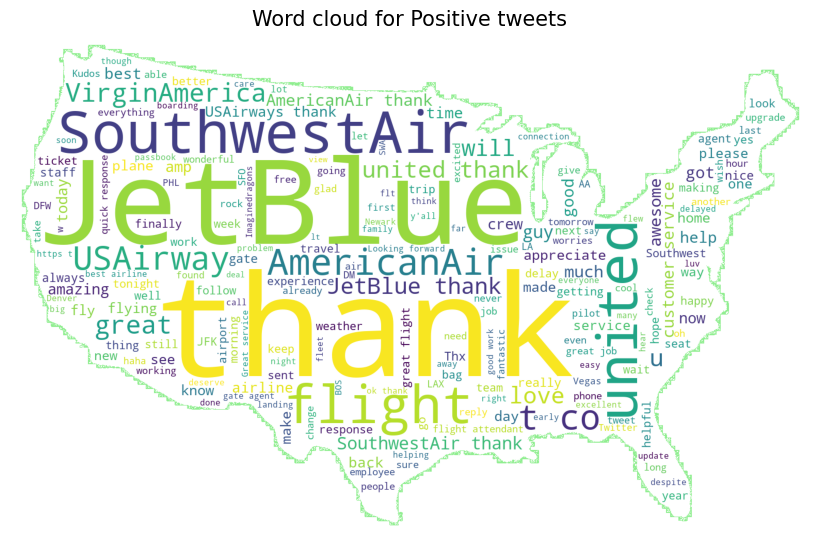

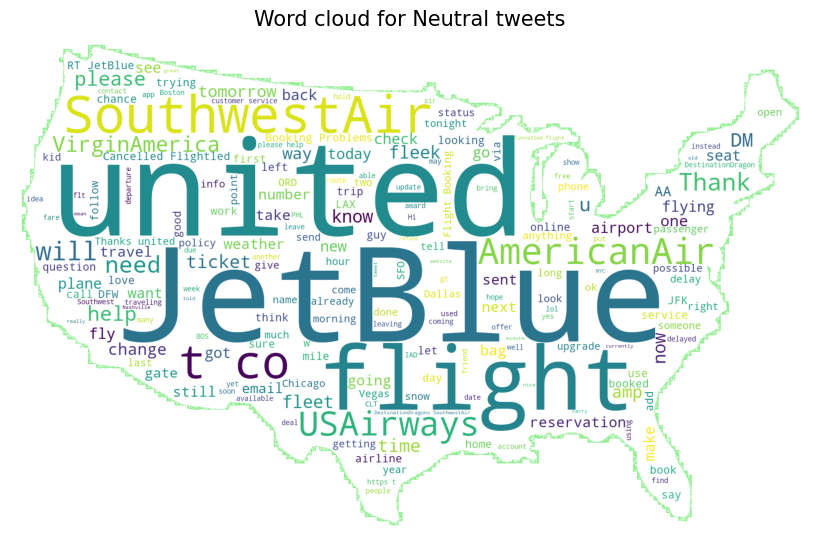

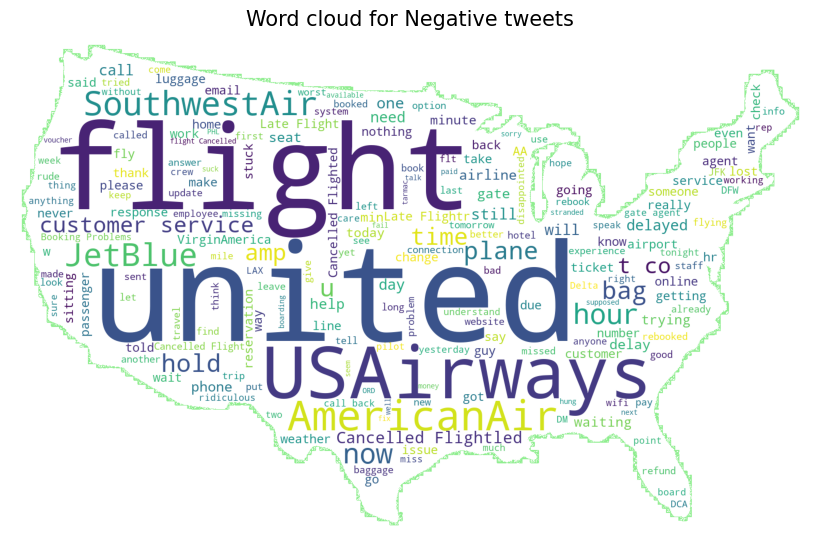

In [9]:
# Wordcloud for tweets

wordcloud(positive_df, 'text', 'Positive tweets')
wordcloud(neutral_df,  'text', 'Neutral tweets')
wordcloud(negative_df, 'text', 'Negative tweets')

Interpretation of word clouds for tweets:

The word cloud for positive tweets shows that the most frequently occuring n-grams are 'thank' and 'Jet Blue'. The word cloud for neutral tweets shows that the most frequently occuring n-grams are 'united', 'Jet Blue' and 'flight'. In both of these word clouds 'Southwestair' are frequently occuring. The word cloud for negative tweets shows that 'flight', 'united' and 'USAirways' are most frequently occuring followed by 'AmericanAir'. It is to be expected that the unigram 'flight' would frequently occur and could be treated as a stop word.

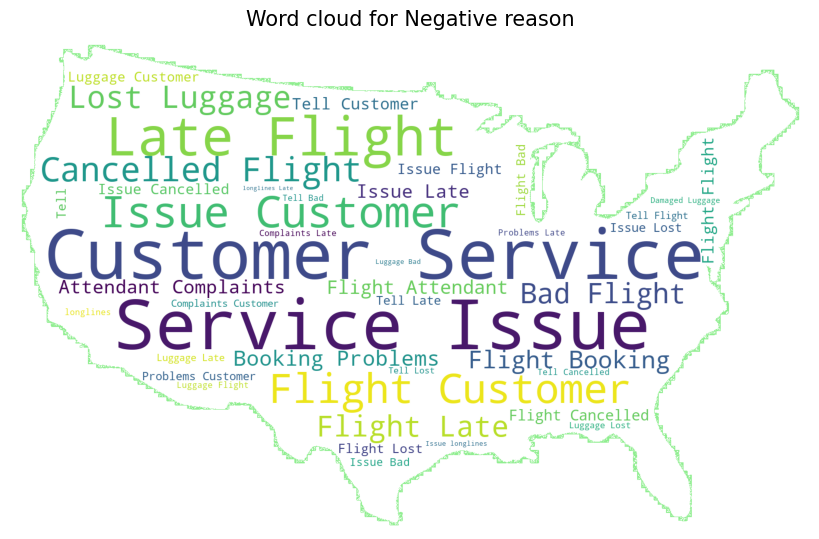

In [10]:
# Wordcloud for negative reason

wordcloud(negative_df, 'negativereason', 'Negative reason')

Interpretation of word cloud for negative reason: 

The bi-grams 'Customer Service' and 'Service Issue' present in the word cloud indicate that these are the most frequently occuring reasons for negative tweets.

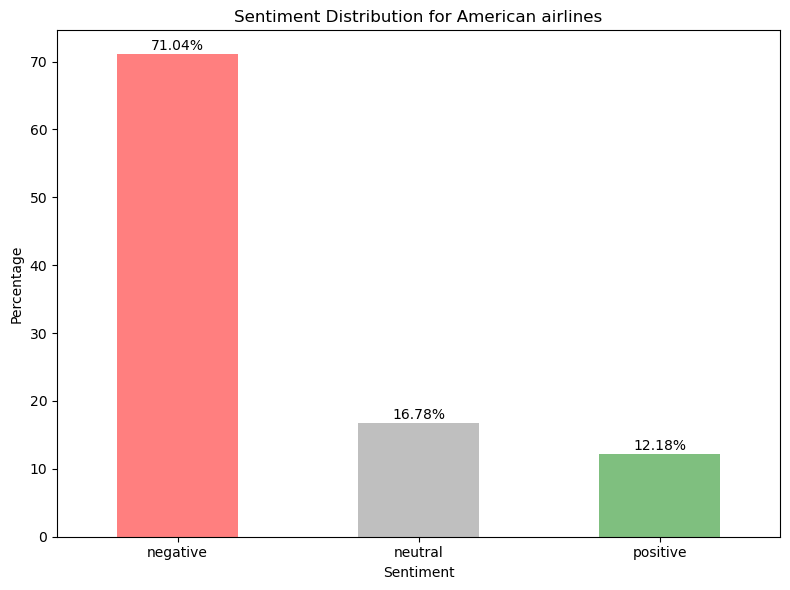

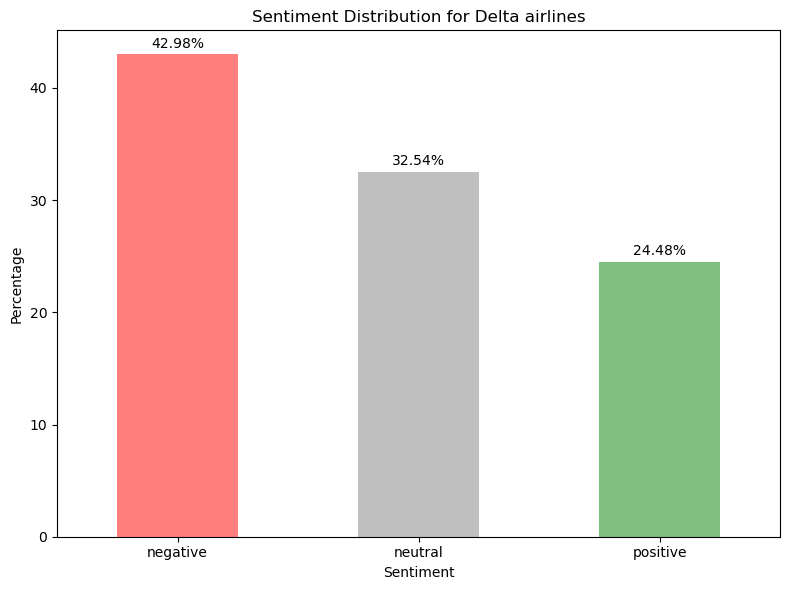

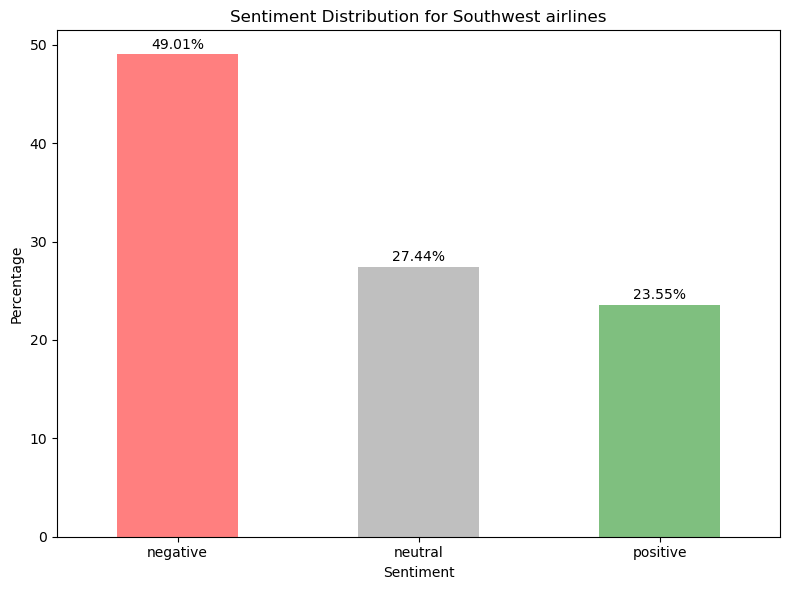

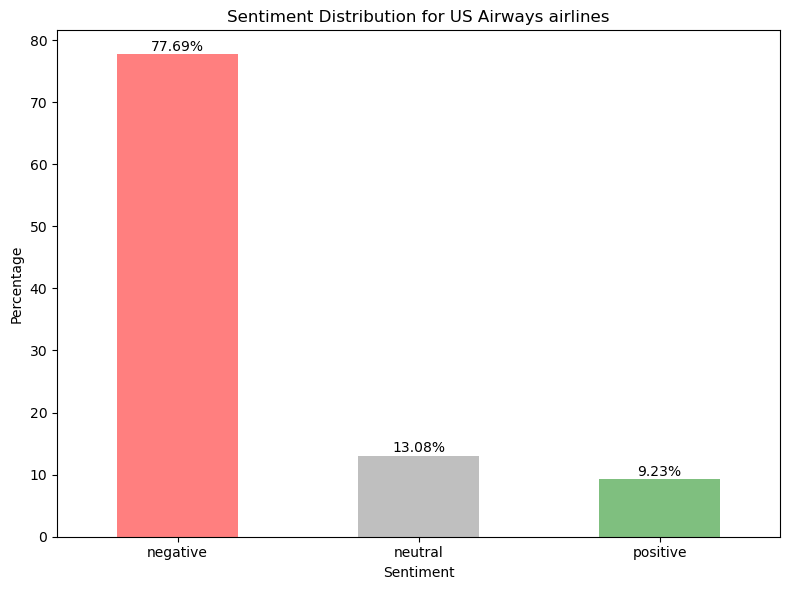

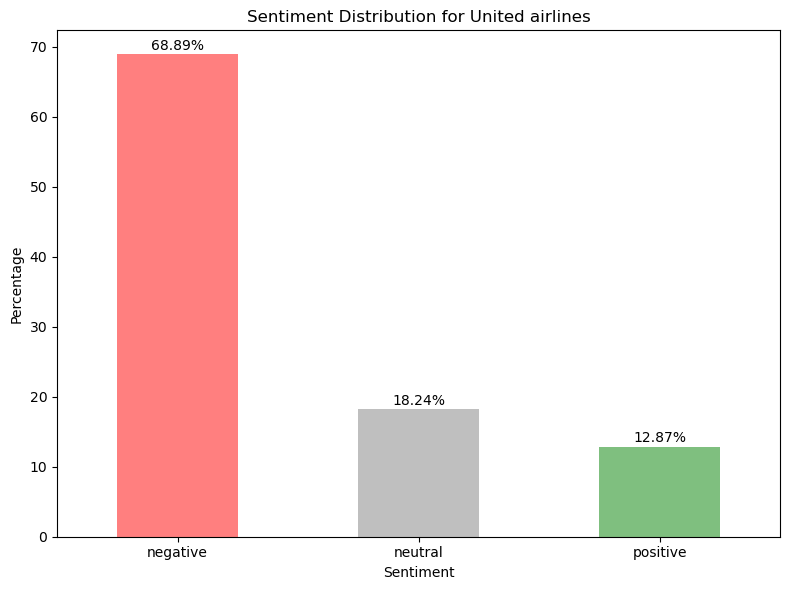

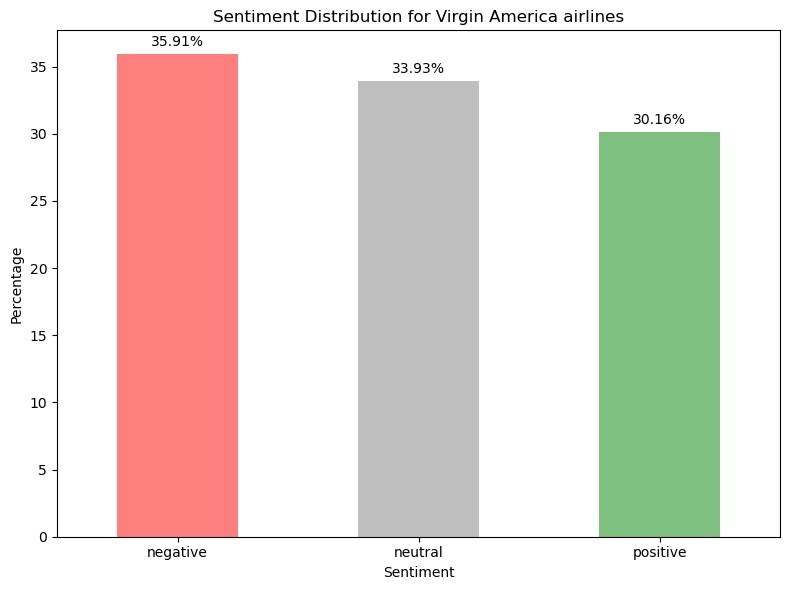

In [11]:
# Bar charts 

def bar_chart(df):
    
    # Group the data by 'Airline_name' and 'Sentiment'
    grouped_data = df.groupby('airline')

    
    # Create subplots for each airline
    for airline_name, group in grouped_data:
        # Calculate sentiment count
        sentiment_count = group['airline_sentiment'].value_counts(normalize=True) * 100
        
        # Plot the bar chart
        plt.figure(figsize=(8, 6))
        sentiment_count.plot(kind='bar', color=['red', 'grey', 'green'], alpha=0.5)
        
        
        # Set title and labels
        plt.title(f"Sentiment Distribution for {airline_name} airlines")
        plt.xlabel('Sentiment')
        plt.ylabel('Percentage')
        plt.xticks(rotation=0)
        
        # Show percentages on top of bars
        for i, value in enumerate(sentiment_count):
            plt.text(i, value + 0.6, f'{value:.2f}%', ha='center')
        
        plt.tight_layout()
        plt.show()


# Call function
bar_chart(df)

Interpretation of bar charts:

A large percentage of the tweets are negative across all airlines except for Virgin America airlines which are roughly balanced across sentiment.

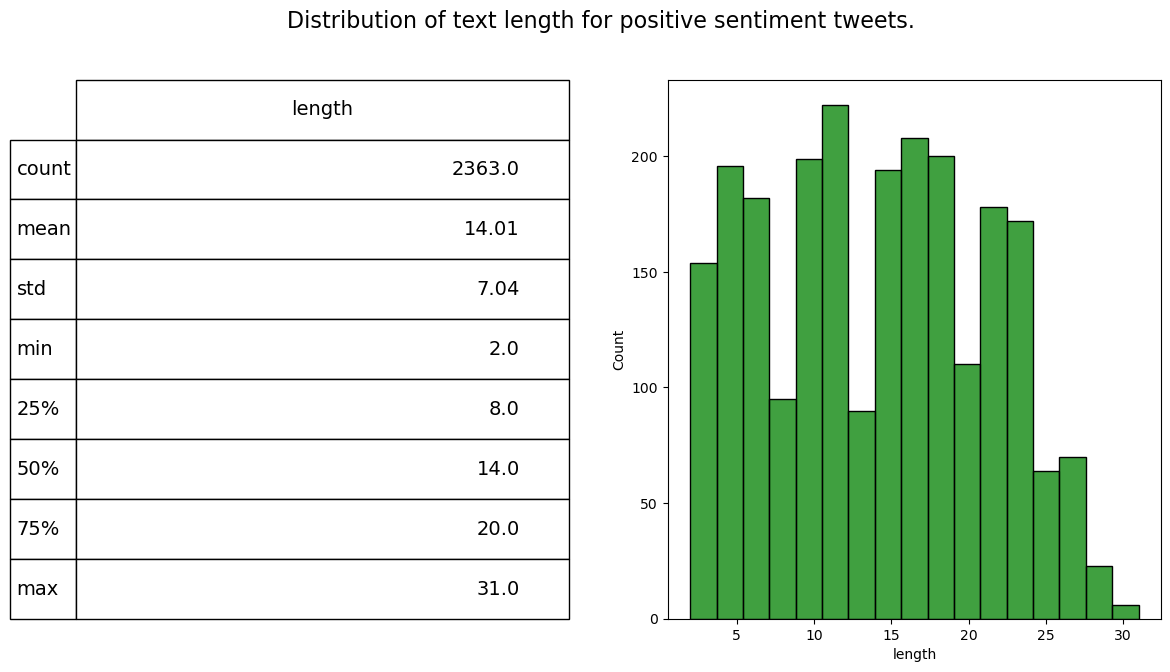

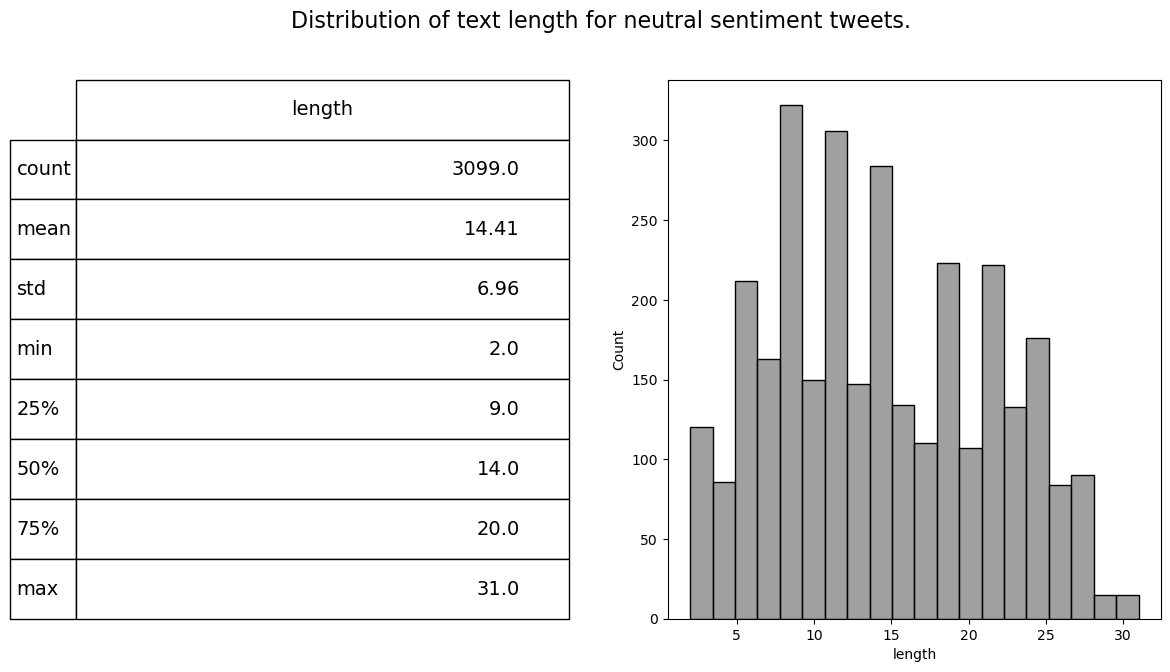

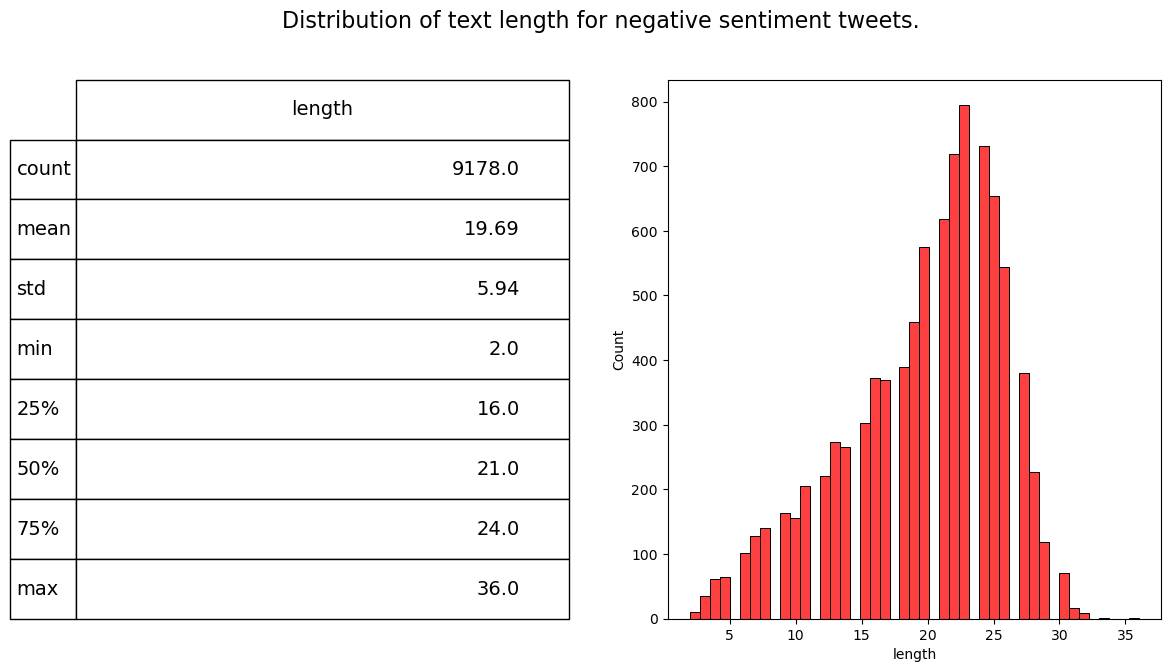

In [12]:
# Distribution of text length by sentiment category

def text_length(df, sentiment, colour):
    fig = plt.figure(figsize=(14,7))
    df['length'] = df.text.str.split().apply(len) # create length variable
    ax1 = fig.add_subplot(122)
    sns.histplot(df[df['airline_sentiment']== sentiment]['length'], ax=ax1,color=colour)
    describe = df.length[df.airline_sentiment== sentiment].describe().to_frame().round(2)
    
    ax2 = fig.add_subplot(121)
    ax2.axis('off')
    font_size = 14
    bbox = [0, 0, 1, 1]
    table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    fig.suptitle(f'Distribution of text length for {sentiment} sentiment tweets.', fontsize=16)
    
    plt.show()


# Call function
text_length(df, 'positive', 'green')
text_length(df, 'neutral', 'grey')
text_length(df, 'negative', 'red')


Interpretations of tweet lengths:

The mean length of positive and neutral tweets is 14 tokens, whereas the mean length of negative tweets is approximately 20 tokens. Negative tweets appear to be longer than positive and neutral tweets. The length of positive and neutral tweets appear to range from 2 to 31 tokens. The legth of negative tweets appear to range from 2 to 36 tokens.

code source: https://www.kaggle.com/code/kritanjalijain/twitter-sentiment-analysis-lstm

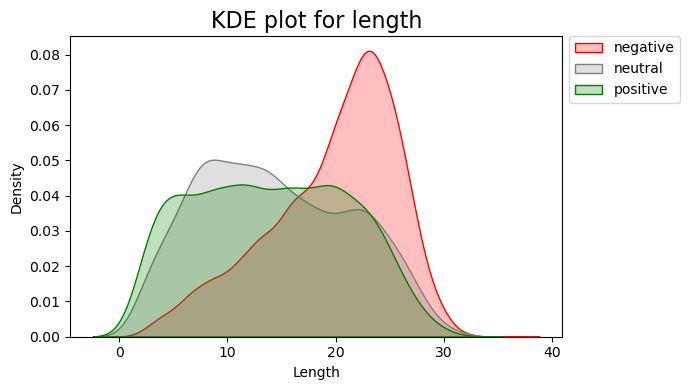

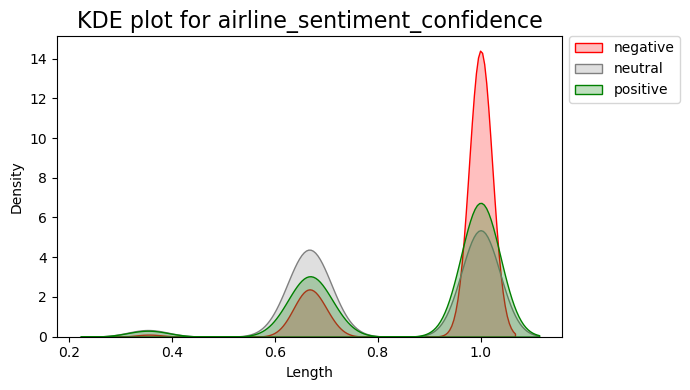

C:\Users\qudsi\AppData\Local\Temp\ipykernel_17256\266790522.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data[variable], fill=True, common_norm=False, color=colours[i], label=sentiment)
C:\Users\qudsi\AppData\Local\Temp\ipykernel_17256\266790522.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data[variable], fill=True, common_norm=False, color=colours[i], label=sentiment)


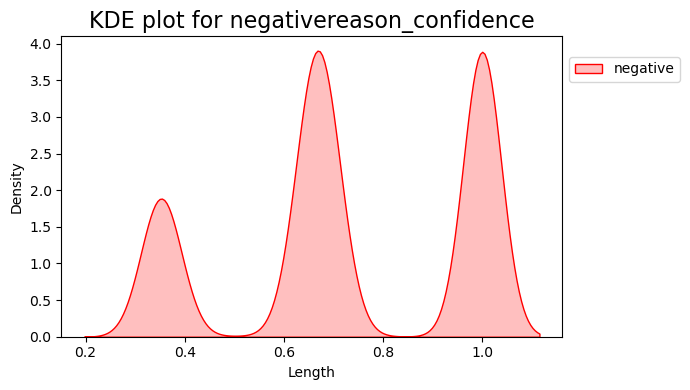

In [13]:
# KDE plots for sentiment confidence and length

def kde_plots(df, variable, colours):
    
    plt.figure(figsize=(7, 4))
    plt.title(f'KDE plot for {variable}', fontsize=16)
    
    # Plot KDE for each sentiment separately
    for i, (sentiment, data) in enumerate(df.groupby('airline_sentiment')):
        sns.kdeplot(data=data[variable], fill=True, common_norm=False, color=colours[i], label=sentiment)
    
    plt.xlabel('Length')
    plt.ylabel('Density')
    
    # Place legend outside the plot
    plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.89))
    
    plt.tight_layout()
    plt.show()

kde_plots(df, 'length', ['red', 'grey', 'green'])
kde_plots(df, 'airline_sentiment_confidence', ['red', 'grey', 'green'])
kde_plots(df, 'negativereason_confidence', 'red')

Interpretation of KDE plots:

The KDE plot for the length of the tweets display a bimodal distribution for neutral tweets. The distribution of the length of positive tweets appear to be uniform.

The distributions of the sentiment confidence and negative reason confidence are multimodal indicating distinct clusters/groups within the data.


Correlation coefficient: -0.2059355918043547


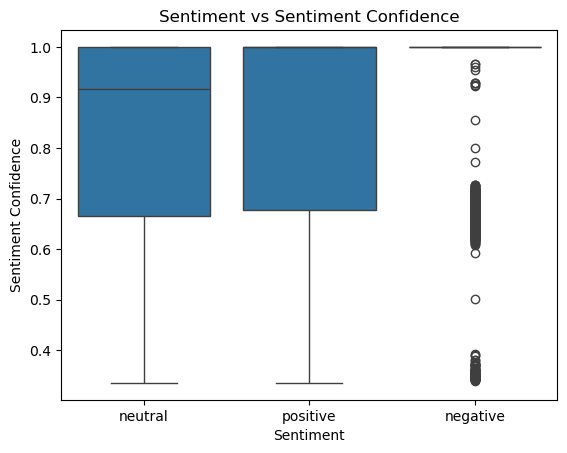

In [14]:
# Calculate correlation
correlation = df['airline_sentiment'].astype('category').cat.codes.corr(df['airline_sentiment_confidence'])


print("Correlation coefficient:", correlation)

# Plot
sns.boxplot(x='airline_sentiment', y='airline_sentiment_confidence', data=df)
plt.title('Sentiment vs Sentiment Confidence')
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Confidence')
plt.show()


Interpretation of correlation:

The correlation coefficient of -0.2059 indicates a weak negative correlation between sentiment and sentiment confidence. The negative sign indicates that sentiment and sentiment confidence are inversely proportional to each other. This means that when a sentiment becomes more positive the sentiment confidence tends to decrease. But this relationship is relatively weak. 

In [15]:
# Count number of tweets per airline
tweets_per_airline = df.groupby('airline').size().reset_index(name='text')

# Sort in descending order based on the count of tweets
tweets_per_airline = tweets_per_airline.sort_values(by='text', ascending=False)

print(tweets_per_airline)

          airline  text
4          United  3822
3      US Airways  2913
0        American  2759
2       Southwest  2420
1           Delta  2222
5  Virgin America   504


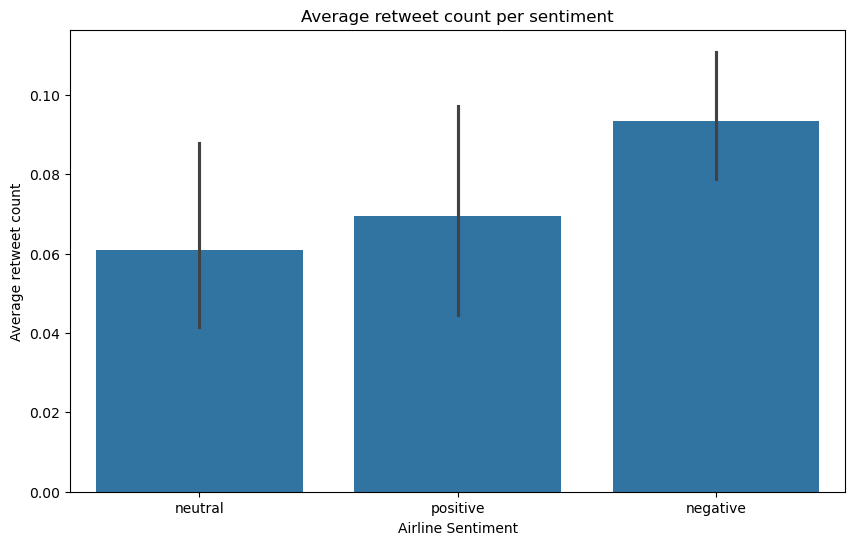

In [16]:
# Create a bar plot of the retweet_count per airline_sentiment

plt.figure(figsize=(10, 6))
sns.barplot(x='airline_sentiment', y='retweet_count', data=df) # default estimator is mean
plt.title('Average retweet count per sentiment')
plt.xlabel('Airline Sentiment')
plt.ylabel('Average retweet count')
plt.show()


Interpretation of bar plot:

It can be seen that negative tweets have a greater average of retweet counts compared to neutral and positive tweets.

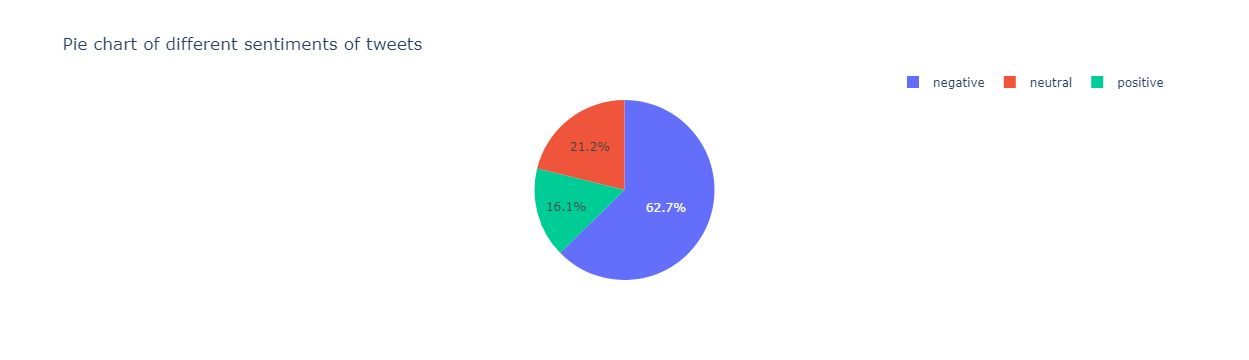

In [17]:
# Pie chart of tweets per sentiment

fig = px.pie(df, names='airline_sentiment', title='Pie chart of different sentiments of tweets')
fig.update_layout(legend=dict(orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1))
fig.show()

Interpretation of pie chart:

It can be seen that 62.7% of the tweets in the data are negative whereas only 16.1% are positive and 21.2% are neutral.

code source: https://www.kaggle.com/code/kritanjalijain/twitter-sentiment-analysis-lstm

# Data preparation

The target variable chosen is airline sentiment along with the predictors retweet count, length and sentiment confidence. It was noticed that there is a distinguishable difference in the retweet count, length and sentiment confidence between positive and neutral tweets compared to negative tweets. Due to there being a majority of negative tweets in the data, positive and neutral tweets will be grouped. The focus for the analysis is on the negative tweets hence an additional reasoning for the grouping. The target variable will be binary defined as:

                                                                    target = {1 if negative,
                                                                              0 otherwise

Data is of moderate size consisting of 14640 rows and was therefore split into a train and test set to evaluate the models performance on unseen data. An 80:20 split was done. This is a commonly used split ratio and is suitable for data of this size. 
                                                                              

In [18]:
# Create target variable

# Label encoding of airline sentiment

# create column called target
"""
    Column target:
    0 if neutral,
    0 if positive,
    1 if negative
"""

df['target'] = 0
df.loc[df['airline_sentiment'] == 'negative', 'target']=1

In [19]:
# Select chosen variables

df_model = df[['target', 'airline_sentiment_confidence', 'retweet_count', 'length']]
df_model.head()

target  airline_sentiment_confidence  retweet_count  length
0       0                        1.0000              0       4
1       0                        0.3486              0       9
2       0                        0.6837              0      12
3       1                        1.0000              0      17
4       1                        1.0000              0      10

In [20]:
# Split data into train and test set

X = df_model[['airline_sentiment_confidence', 'retweet_count', 'length']]
y = df_model['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58) # 80% train and 20% test

In [21]:
# Check dimensions of split

print("Training set dimensions:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nTest set dimensions:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set dimensions:
X_train: (11712, 3)
y_train: (11712,)

Test set dimensions:
X_test: (2928, 3)
y_test: (2928,)


# Modelling
Predict the sentiment of a tweet based on the retweet count, length and sentiment confidence by building a Bayesian logistic regression model. This model is chosen due to the data being multimodal and the target being classification.

sources for code: https://www.youtube.com/watch?v=911d4A1U0BE&t=33s
                  https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html


In [22]:
# Finding mean and standard deviation of variables in training set

# Calculate mean and standard deviation for each variable
sentiment_confidence_mean = np.mean(X_train['airline_sentiment_confidence'])
sentiment_confidence_std = np.std(X_train['airline_sentiment_confidence'])

length_mean = np.mean(X_train['length'])
length_std = np.std(X_train['length'])

retweet_count_mean = np.mean(X_train['retweet_count'])
retweet_count_std = np.std(X_train['retweet_count'])


print("Sentiment Confidence - Mean:", sentiment_confidence_mean, "Standard Deviation:", sentiment_confidence_std)
print("Length - Mean:", length_mean, "Standard Deviation:", length_std)
print("Retweet Count - Mean:", retweet_count_mean, "Standard Deviation:", retweet_count_std)

Sentiment Confidence - Mean: 0.900384537226776 Standard Deviation: 0.16292549532779815
Length - Mean: 17.654456967213115 Standard Deviation: 6.8874675040285895
Retweet Count - Mean: 0.0823087431693989 Standard Deviation: 0.7723587976633195


Build model

In [23]:
az.style.use("arviz-darkgrid")
seed = np.random.default_rng(58) # set seed

# Standardise predictors
X_train_scaled = {
    'airline_sentiment_confidence': (X_train['airline_sentiment_confidence'] - sentiment_confidence_mean) / sentiment_confidence_std,
    'length': (X_train['length'] - length_mean) / length_std,
    'retweet_count': (X_train['retweet_count'] - retweet_count_mean) / retweet_count_std
}

# Define the PyMC model
with pm.Model() as logistic_model:
    
    # Priors for coefficients
    # specify distributions for each predictor
    """ Normal distributions are used for each variable, according to the KDE plots displaying some normality but other distributions can be investigated """
    beta_sentiment_confidence = pm.Normal('beta_sentiment_confidence', mu=0, sigma=10) 
    beta_length = pm.Normal('beta_length', mu=0, sigma=10)
    beta_retweet_count = pm.Normal('beta_retweet_count', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)

    
    # Logistic transformation of linear predictor
    linear_predictor = (
        beta_sentiment_confidence * X_train_scaled['airline_sentiment_confidence'] +
        beta_length * X_train_scaled['length'] +
        beta_retweet_count * X_train_scaled['retweet_count'] +
        intercept
    )
    p = pm.math.sigmoid(linear_predictor) #  applies sigmoid transformation to linear combination of predictors
    
    # Likelihood (Bernoulli distribution for binary target variable)
    likelihood = pm.Bernoulli('target', p=p, observed=y_train)
    
    # Inference
    trace = pm.sample(random_seed=seed) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_sentiment_confidence, beta_length, beta_retweet_count, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.


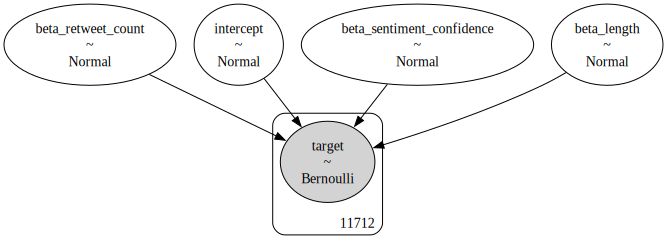

In [24]:
# Visualise model 

pm.model_to_graphviz(logistic_model)

Analyse results

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_sentiment_confidence, beta_length, beta_retweet_count, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
C:\Users\qudsi\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:487: UserWarning:

Your data appears to have a single value or no finite values

C:\Users\qudsi\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:487: UserWarning:

Your data appears to have a single value or no finite values

C:\Users\qudsi\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:487: UserWarning:

Your data appears to have a single value or no finite values

C:\Users\qudsi\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:487: UserWarning:

Your data appears to have a single value or no finite values



array([[<Axes: title={'center': 'beta_sentiment_confidence'}>,
        <Axes: title={'center': 'beta_sentiment_confidence'}>],
       [<Axes: title={'center': 'beta_length'}>,
        <Axes: title={'center': 'beta_length'}>],
       [<Axes: title={'center': 'beta_retweet_count'}>,
        <Axes: title={'center': 'beta_retweet_count'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

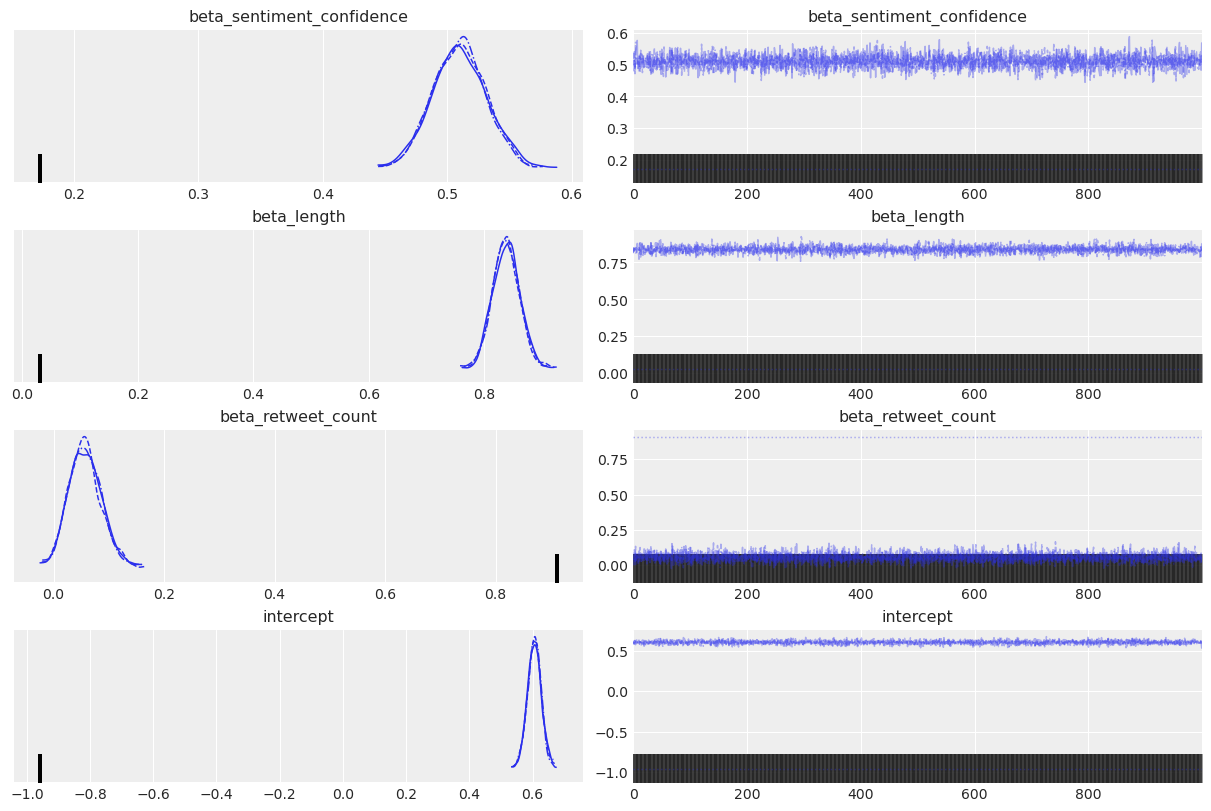

In [25]:
# Analyse results
with logistic_model:
    trace.extend(pm.sample(random_seed=seed))

az.plot_trace(trace)

In [26]:
# Generate posterior predictive samples based on the posterior distribution of the model parameters obtained from the trace 

with logistic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=seed)

Sampling: [target]


array([<Axes: title={'center': 'beta_sentiment_confidence'}>,
       <Axes: title={'center': 'beta_length'}>,
       <Axes: title={'center': 'beta_retweet_count'}>], dtype=object)

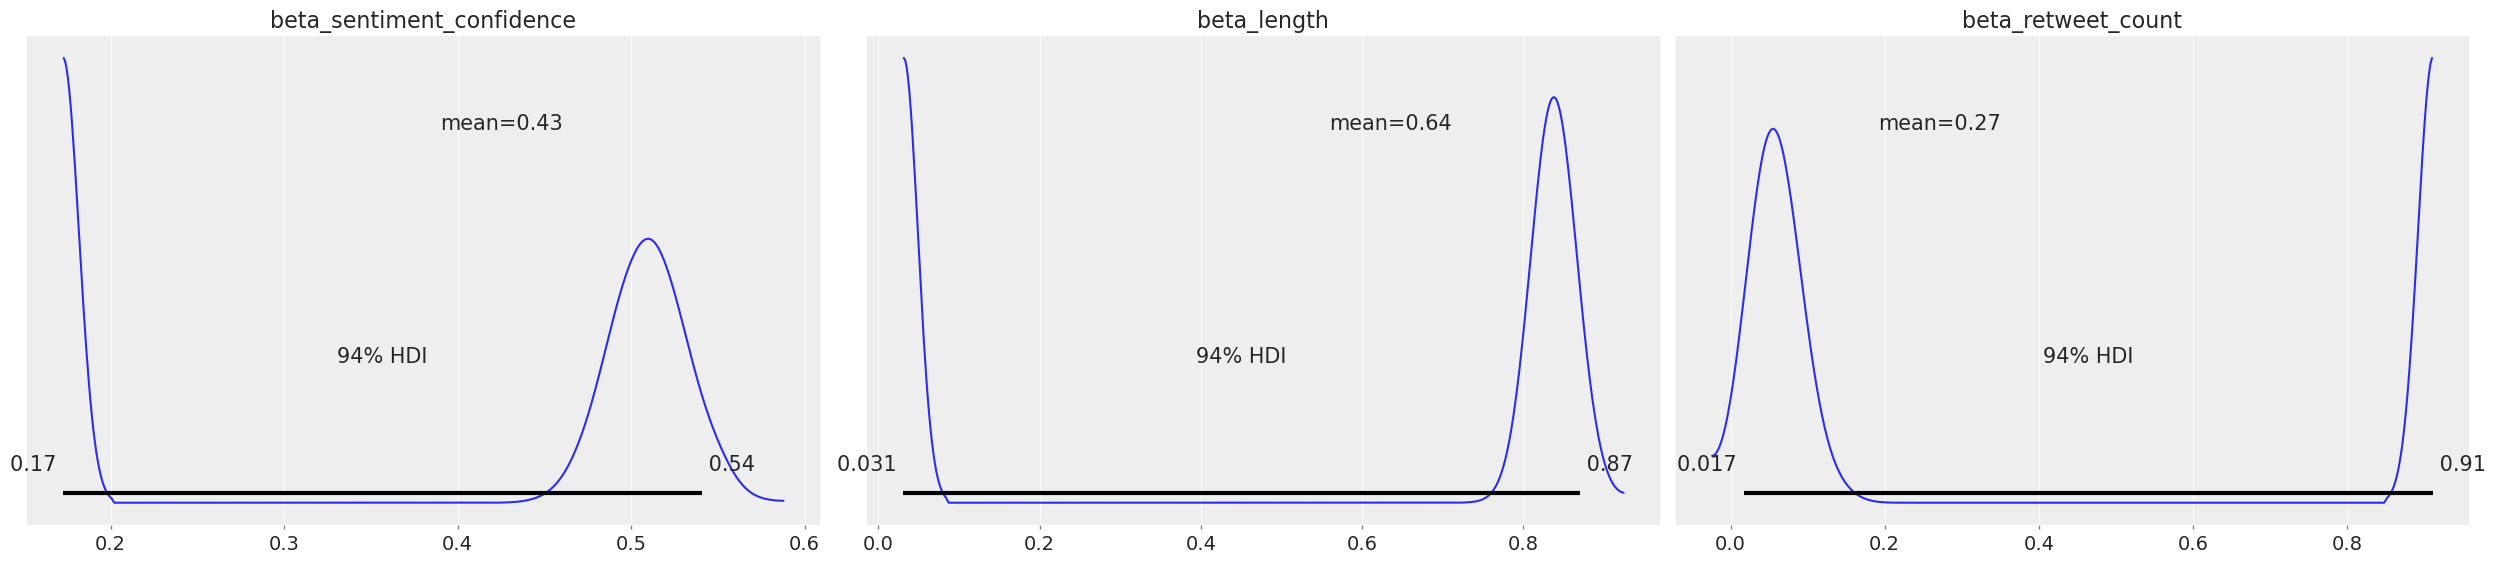

In [27]:
# Visualise posterior distributions of the model parameters obtained

az.plot_posterior(trace, var_names=['beta_sentiment_confidence', 'beta_length', 'beta_retweet_count'])

C:\Users\qudsi\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\ppcplot.py:267: FutureWarning:

The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.

C:\Users\qudsi\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\ppcplot.py:271: FutureWarning:

The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.



<Axes: xlabel='target'>

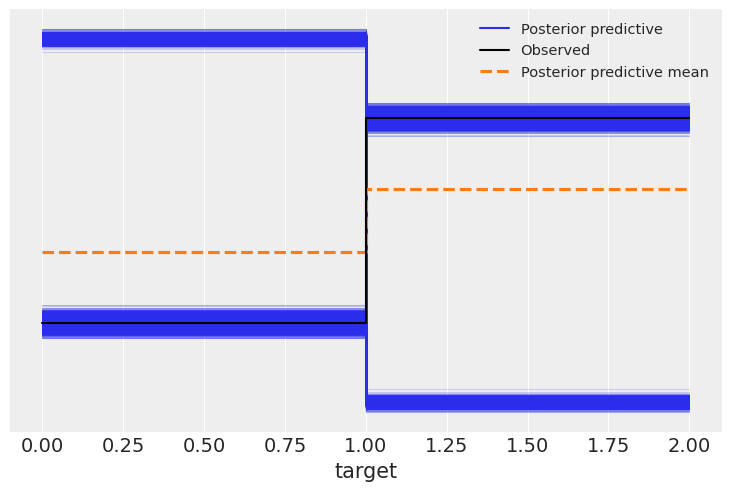

In [28]:
# Visualise the posterior predictive distribution of the model

az.plot_ppc(trace)

Interpretation of PPC plot:

The posterior predictive mean being further away from the observed data and model's predictions (posterior predictive) indicates that the model is not adequately capturing patterns present in the data.

# Evaluate model

Evaluation metrics used are accuracy, precision, recall and F1 score. These metrics are commonly used in evaluating classification models. Looking at all four metrics provides insights into the strength and weaknesses of the model across different aspects of it's performance. Precision focuses on the ratio of the number of true positives to the total number of cases predicted as positive. Recall quantifies the ratio of the number of true positives to the total number of actual positive cases. The F1 score calculates a combined measure between precision and recall. 

In [32]:
with logistic_model:
    p_train = p.eval()

# Convert PyMC tensor to NumPy array
predicted_labels_train = (p_train >= 0.5).astype(int)

# Calculate precision, recall, and F1 score for the training set
accuracy_train  = accuracy_score(y_train, predicted_labels_train)
precision_train = precision_score(y_train, predicted_labels_train)
recall_train    = recall_score(y_train, predicted_labels_train)
f1_train        = f1_score(y_train, predicted_labels_train)


print("Training Accuracy:", accuracy_train)
print("Training Precision:", precision_train)
print("Training Recall:", recall_train)
print("Training F1 Score:", f1_train)

Training Accuracy: 0.6257684426229508
Training Precision: 0.625821876867902
Training Recall: 0.9998635743519781
Training F1 Score: 0.7698125098471719


Interpretation of training metrics:

The model has an overall accuracy of 62.5%. The precision indicates that out of all the tweets that the model predicted as negative, 62.5% of them were actually negative. Out of all the actual negative tweets in the dataset, the model correctly identified 99.9% of them. The F1 score of 0.77 indicates that the model achieves a balanced performance in terms of precision and recall.

# Validate model on test set

In [30]:
# Standardise predictors in the test set
X_test_scaled = {
    'airline_sentiment_confidence': (X_test['airline_sentiment_confidence'] - sentiment_confidence_mean) / sentiment_confidence_std,
    'length': (X_test['length'] - length_mean) / length_std,
    'retweet_count': (X_test['retweet_count'] - retweet_count_mean) / retweet_count_std
}

# Logistic transformation of linear predictor for the test set
with logistic_model:
    linear_predictor_test = (
        beta_sentiment_confidence * X_test_scaled['airline_sentiment_confidence'] +
        beta_length * X_test_scaled['length'] +
        beta_retweet_count * X_test_scaled['retweet_count'] +
        intercept
    )
    p_test = pm.math.sigmoid(linear_predictor_test)

# Predicted probabilities for the test set
predicted_probabilities = p_test.eval()

In [31]:
# Evaluate model performance using predicted and actual labels in the test set

# Predicted labels based on the predicted probabilities
predicted_labels = (predicted_probabilities >= 0.5).astype(int)

# Calculate accuracy, precision, recall, and F1 score
accuracy_test  = accuracy_score(y_test, predicted_labels)
precision_test = precision_score(y_test, predicted_labels)
recall_test    = recall_score(y_test, predicted_labels)
f1_test        = f1_score(y_test, predicted_labels)


print("Test Accuracy:",  accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:",    recall_test)
print("Test F1 Score:",  f1_test)

Test Accuracy: 0.6308060109289617
Test Precision: 0.6310215237444482
Test Recall: 0.9994588744588745
Test F1 Score: 0.7736125654450262


Interpretation of test metrics:

The model has an overall accuracy of 63%. The precision indicates that out of all the tweets that the model predicted as negative, 63% of them were actually negative. Out of all the actual negative tweets in the dataset, the model correctly identified 99.9% of them. The F1 score of 0.77 indicates that the model achieves a balanced performance in terms of precision and recall.

# Conclusion



Despite the discrepencies between the train and test metrics being small, the performance is not great. Alternative distributions can be explored for the predictor variables to improve model performance.